In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

6.016088008880615 1475083110.5835354


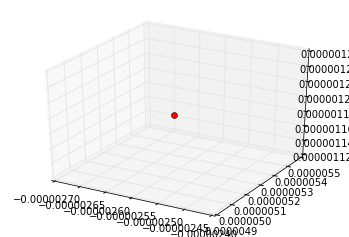

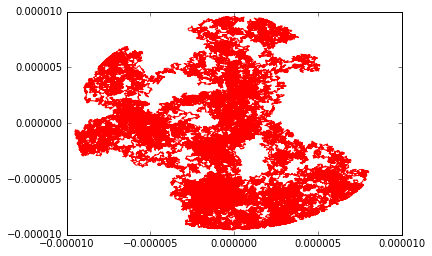

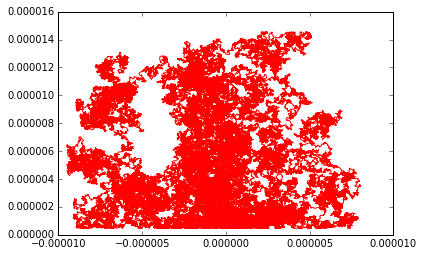

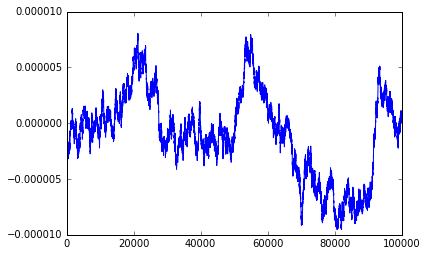

In [33]:
# N = 3
eta = 1.0e-3
kB = 1.38e-23
T = 293

preD = kB * T / (3 * np.pi * eta)

r = 10 * 1e-6
h = 1.5 * 1e-5
min_d = 1e2 * 1e-9
max_d = 1e3 * 1e-9

max_D = preD / min_d
deltaT = r**2 / (2 * N * max_D) / 1000
deltaCount = 100000

def to_xyz(array):
    alpha, r, h = array
    return np.array([array[1] * np.cos(array[0]), array[1] * np.sin(array[0]), h])

def generate_population(size):
    ds = np.random.uniform(min_d, max_d, [size, 1])

    hs = np.random.uniform(ds * 0.5, h - ds * 0.5, [size, 1])
    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    rs = np.random.uniform(0, r - ds * 0.5, [size, 1])
    
    coords = np.apply_along_axis(to_xyz, 1, np.hstack([alphas, rs, hs]))
    
    return np.hstack([coords, ds])

def generate_displacement(generation):
    sigmas = np.sqrt(2 * preD / generation[:, 3] * deltaT)
    return np.random.randn(generation.shape[0], generation.shape[1] - 1) * sigmas[:, np.newaxis]

def stay_in_bounds(array):
    z_pos = array[2] + array[-1]
    sqr_r_pos = (array[0] + array[-3]) ** 2 + (array[1] + array[-2]) ** 2
    d2 = array[3] / 2
    
    if 0 <= z_pos - d2 and z_pos + d2 <= h and sqr_r_pos <= (r - d2) ** 2:
        array[:3] += array[-3:]
    return array[:4]

def plot_generation(generation, *args):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(generation[:, 0], generation[:, 1], generation[:, 2], *args)
    return ax

generation = generate_population(1)
plot_generation(generation, 'ro')

start = time.time()

coords = np.zeros((deltaCount, 3))
for i in range(deltaCount):
    coords[i, :] = generation[0, :3]
    
    deltas = generate_displacement(generation)
    generation = np.apply_along_axis(stay_in_bounds, 1, np.hstack([generation, deltas]))
coords = np.vstack(coords)

print(time.time() - start, time.time())

fig = plt.figure()
ax = fig.gca()
# ax.add_artist(plt.Circle((0, 0), r, color='b'))
ax.plot(coords[:, 0], coords[:, 1], 'r')
# ax.add_artist(plt.Circle((coords[-1, 0], coords[-1, 1]), generation[0, -1] * 0.5, color='r'))
plt.show()
plt.plot(coords[:, 0], coords[:, 2], 'r')
plt.show()
plt.plot(np.arange(len(coords[:, 0])), coords[:, 0])


In [ ]:
while True:
    generation = np.hstack([np.zeros((1000, 3)), min_d * np.ones((1000, 1))])
    for i in range(count):
        deltas = generate_displacement(generation)
        generation = np.apply_along_axis(stay_in_bounds, 1, np.hstack([generation, deltas]))

    delta_squared = generation[:, 0] ** 2 + generation[:, 1] ** 2 + generation[:, 2] ** 2
    print(preD / min_d, delta_squared.mean() / (2 * N * deltaT * count))
break